## ToDo
    Tune parameters for HMI Images 
    Ensure identical results are obtain for corresponding MDI images
    
    Explore convolution without taking the abs of the data
    For MDI, focus on the right most sunspots for kernel performance 

In [1]:
#import astropy
from astropy.io import fits
from math import pi, sin, cos, sqrt, atan2
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import extract_image_features as extract

ImportError: No module named extract_image_features

### User Defined Functions
    Get image parameters 
    Map images to Equal Area Cylindrical Distance

In [2]:
def get_header_params_MDI(header):
    '''Gets parameters from MDI image file that are required to 
       perform an Equal Area Map Cylindrical Projection 
       INPUT:  Image header
       OUTPUT: 
               x-center, Distance along x-axis to center of solar disk from first pixel center in array pixels
               y-center, Distance along y-axis to center of solar disk from first pixel center in array pixels
               s0,       Semi-diameter of solar image
               nx,       Number of pixels in x and y dimension (assuming square image)
               pixsize,  Pixel size in arc seconds per pixel
               p0,       Polar angle offset between sun and image vertical axis
               b0,       Longatudinal offset between sun equator and image horizontal axis
               r0,       Radius of the solar disk in pixels
    '''
    xCen = header["X0"]
    yCen = header["Y0"]
    s0 = header["OBS_R0"]
    nx = header["NAXIS1"]
    pixsize = header["FD_SCALE"]
    p0 = header["P_ANGLE"]
    b0 =header["OBS_B0"]
    r0 = s0/pixsize
    yCen = xCen + 0.5
    yCen = yCen + 0.5
    p0 = p0 - 0.21
    return xCen,yCen,s0,nx,pixsize,p0,b0, r0

In [3]:
def get_header_params_HMI(header):
    '''Gets parameters from HMI image file that are required to 
       perform an Equal Area Map Cylindrical Projection 
       INPUT:  Image header
       OUTPUT: 
               x-center, Distance along x-axis to center of solar disk from first pixel center in array pixels
               y-center, Distance along y-axis to center of solar disk from first pixel center in array pixels
               s0,       Semi-diameter of solar image
               nx,       Number of pixels in x and y dimension (assuming square image)
               pixsize,  Pixel size in arc seconds per pixel
               p0,       Polar angle offset between sun and image vertical axis
               b0,       Longatudinal offset between sun equator and image horizontal axis
               r0,       Radius of the solar disk in pixels
    '''
    xCen = header["CRPIX1"]
    yCen = header["CRPIX2"]
    s0 = header["RSUN_OBS"]
    nx = header["NAXIS1"]
    pixsize = header["CDELT1"]
    p0 = header["CROTA2"]
    b0 =header["CRLT_OBS"]
    r0 = s0/pixsize
    
    # Shift origin from center of pixel to lower left of pixel
    yCen = xCen + 0.5
    yCen = yCen + 0.5
    # Correct for the misalignment of the CCD with the satellite
    p0 = -p0
    return xCen,yCen,s0,nx,pixsize,p0,b0, r0

In [4]:
def map_disk_cylindric(xCen,yCen,s0,nx,pixsize,p0,b0, r0, v, dim = 4):
    '''Performs an Equal Area Map Cylindrical Projection 
       INPUT: 
               x-center, Distance along x-axis to center of solar disk from first pixel center in array pixels
               y-center, Distance along y-axis to center of solar disk from first pixel center in array pixels
               s0,       Semi-diameter of solar image
               nx,       Number of pixels in x and y dimension (assuming square image)
               pixsize,  Pixel size in arc seconds per pixel
               p0,       Polar angle offset between sun and image vertical axis
               b0,       Longatudinal offset between sun equator and image horizontal axis
               r0,       Radius of the solar disk in pixels
       OUTPUT: transformed data as an array
    '''
    
   
    vmap = np.empty([nx,nx]) # create array for transformed data
    wx = np.empty([dim,dim])
    wy = np.empty([dim,dim])
    data = np.empty([dim,dim])
    
    pihalf=pi/2.             # pi/2
    rsq=r0*r0                # radius of solar disk squared 
    rsqtest= (r0-2.)*(r0-2.) # exclude the two pixels at the limb
    sr=s0*pi/(180.*3600.)    # convert semi-diameter units from arcseconds to radians
    sins0=sin(sr)            # sin component of semi-diameter
    coss0=cos(sr)            # cos component of semi-diameter
    radsol=r0*coss0          # solar radius 

    # Trignometric factors for position angle of rotation axis (wrt vertical axis of image)
    cosp0=cos(p0*pi/180.)
    sinp0=sin(p0*pi/180.)

    # Trignometric factors for tilt angle of rotation axis (latitude at disk center), wrt horizontal axis of image
    cosb0=cos(b0*pi/180.)
    sinb0=sin(b0*pi/180.)

    # Maximum z position for image pixels to be visible
    zpmin=radsol*sins0

    # Heliographic coordinate step sizes
    dcosTheta=2./nx
    dphi=pi/nx

    pihalf=pi/2.             # pi/2
    rsq=r0*r0                # radius of solar disk squared 
    rsqtest= (r0-2.)*(r0-2.) # exclude the two pixels at the limb
    sr=s0*pi/(180.*3600.)    # convert semi-diameter units from arcseconds to radians
    sins0=sin(sr)            # sin component of semi-diameter
    coss0=cos(sr)            # cos component of semi-diameter
    radsol=r0*coss0          # solar radius 

    # Trignometric factors for position angle of rotation axis (wrt vertical axis of image)
    cosp0=cos(p0*pi/180.)
    sinp0=sin(p0*pi/180.)

    # Trignometric factors for tilt angle of rotation axis (latitude at disk center), wrt horizontal axis of image
    cosb0=cos(b0*pi/180.)
    sinb0=sin(b0*pi/180.)

    # Maximum z position for image pixels to be visible
    zpmin=radsol*sins0

    # Heliographic coordinate step sizes
    dcosTheta=2./nx
    dphi=pi/nx
    
    
    # Latitude at pixel center

    # South pole is at bottom edge of bottom row of pixels
    # North pole is at top edge of top row of pixels

    # TODO: Check the i,j indexing and make sure that you understand 
    #       why they are included angle calculations !
    for j in xrange(1, nx + 1): # rows, range [1,1024]
        cosTheta = -1.0 + (j-0.5) * dcosTheta
        sinb = cosTheta
        cosb = sqrt(1. - sinb*sinb)

        for i in xrange(1, nx + 1): # cols, range [1,1024]

            # Longitude at pixel center
            # Central meridian goes through the leading edge of pixel column at i=nx/2

            phi=(i-0.5)*dphi-pihalf
            cosphi=cos(phi)
            sinphi=sin(phi)

            # Heliographic cartesian coordinates
            xs=radsol*sinphi*cosb
            ys=radsol*sinb
            zs=radsol*cosphi*cosb

            # Rotated Heliographic cartesian coordinates with B-angle
            xb=xs
            yb=cosb0*ys - sinb0*zs
            zb=cosb0*zs + sinb0*ys

            # Rotated Heliographic cartesian coordinates with CCW P-angle
            xp=cosp0*xb - sinp0*yb
            yp=cosp0*yb + sinp0*xb
            zp=zb

            # Test for visibility (skip if point is behind limb)
            if (zp > zpmin):
                # Image coordinate transformation for perspective effects
                rhop=sqrt(xp*xp + yp*yp)
                thetap=0.0

                if (rhop >  0.):
                    thetap=atan2(yp,xp)

                rhoi=rhop*(1.0 + zp/(radsol/sins0 - zp))
                x=rhoi*cos(thetap)
                y=rhoi*sin(thetap)

                xi=xCen + x
                yi=yCen + y

                radsq=x*x + y*y

                # Exclude pixels near the limb
                if (radsq < rsqtest):
                    ix=int(xi)
                    iy=int(yi)
                    dx=xi-ix
                    dy=yi-iy


                    # Bi-cubic interpolation from adjacent points.
                    #data = v[ix-2:ix+2, iy-2:iy+2]
                    #      v[rows, cols]
                    data = v[iy-2:iy+2, ix-2:ix+2]

                    # Weights for cubic interpolation
                    dx2=dx*dx
                    dx3=dx*dx2
                    dy2=dy*dy
                    dy3=dy*dy2

                    for ind in xrange(0,4):
                        wx[ind, 0:4] =  [-0.5*dx + dx2 - 0.5*dx3, \
                                         1.0 - 2.5*dx2 + 1.5*dx3,\
                                         0.5*dx + 2.*dx2 - 1.5*dx3,\
                                                -0.5*dx2 + 0.5*dx3]

                        wy[0:4, ind] = [-0.5*dy + dy2 - 0.5*dy3,\
                                        1.0 - 2.5*dy2 + 1.5*dy3,\
                                        0.5*dy + 2.*dy2 - 1.5*dy3,\
                                               -0.5*dy2 + 0.5*dy3]

                    weight = wx*wy # Broadcasting a row with a col 
                    #vmap[i,j]= np.sum(weight*data)
                    vmap[j-1,i-1]= np.sum(weight*data)
    return vmap

### Import HMI & MDI pair images

In [5]:
# navagate to image location
pair_image_home = "/Users/Alexander/NASA/NASA_Sample_Data/HMI_MDI_test_data/test_pair_1/"
hmi_path = pair_image_home + "HMI.m2011.01.01_00.00.00.fits"
mdi_path = pair_image_home + "fd_M_96m_01d.6574.0000.fits"

In [6]:
# load images 
hdulist_hmi =  fits.open(hmi_path)
hdulist_mdi =  fits.open(mdi_path)

In [7]:
# meta-data of hmi image
hdulist_hmi.info()

Filename: /Users/Alexander/NASA/NASA_Sample_Data/HMI_MDI_test_data/test_pair_1/HMI.m2011.01.01_00.00.00.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       8   ()              
1                ImageHDU       100   (4096, 4096)   int32 (rescales to float64)   


In [8]:
# meta-data of mdi image
hdulist_mdi.info()

Filename: /Users/Alexander/NASA/NASA_Sample_Data/HMI_MDI_test_data/test_pair_1/fd_M_96m_01d.6574.0000.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     182   (1024, 1024)   float32   


In [9]:
# image is located in index 1
hud_hmi = hdulist_hmi[1]

In [10]:
# image is located in index 0
hud_mdi =  hdulist_mdi[0]

### Headers

In [11]:
hud_mdi.header

SIMPLE  =                    T / file conforms with FITS standard; SOI V6R1B0   
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
COMMENT Data from the Solar Oscillations Investigation / Michelson Doppler      
COMMENT   Imager (SOI/MDI) on the Solar and Heliospheric Observatory (SOHO).    
COMMENT For information on data rights, keyword definitions, and up-to-date     
COMMENT   reports on known problems and data quality, see:                      
COMMENT   http://soi.stanford.edu/data.html                                     
HISTORY created by mdical Thu Jan  6 14:31:39 2011                              
HISTORY created by MDI_image_reconstructor Thu Jan  6 16:00:06 2011             
HISTORY An MDI magnetogram z

In [12]:
hud_hmi.header

 [astropy.io.fits.verify]


XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4096 / length of data axis 1                          
NAXIS2  =                 4096 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
DATE    = '2011-02-02T01:50:19'                                                 
DATE-OBS= '2010-12-31T23:58:10.20'                                              
TELESCOP= 'SDO/HMI'                                                             
INSTRUME= 'HMI_SIDE1'                                                           
WAVELNTH= 6173.0                                                                
CAMERA  =                   

### Clean Data

In [13]:
# move data to dataframe
df_mdi = pd.DataFrame(hud_mdi.data)
df_hmi =  pd.DataFrame(hud_hmi.data)

In [14]:
# replace 'NaN' with 0
df_mdi.fillna(value=0,inplace=True)
df_hmi.fillna(value=0,inplace=True)

In [15]:
# move data to arrays
clean_data_mdi = df_mdi.values
clean_data_hmi= df_hmi.values

### Equal Area Transformation (MDI)

In [16]:
# extract parameters from header
xCen,yCen,s0,nx,pixsize,p0,b0, r0 = get_header_params_MDI(hud_mdi.header)

In [17]:
# transform data into cylindrical equal area map
start = time()
trans_data_mdi = map_disk_cylindric(xCen,yCen,s0,nx,pixsize,p0,b0, r0, clean_data_mdi)
end = time()
print "Time Elapsed = {:.4} secs".format(end - start)

Time Elapsed = 21.91 secs


### Equal Area Transformation (HMI)

In [18]:
# extract parameters from header
xCen_2, yCen_2, s0_2, nx_2, pixsize_2, p0_2, b0_2, r0_2 = get_header_params_HMI(hud_hmi.header)

In [19]:
# transform data into cylindrical equal area map
start = time()
trans_data_hmi = map_disk_cylindric(xCen_2,yCen_2,s0_2,nx_2,pixsize_2,p0_2,b0_2, r0_2, clean_data_hmi)
end = time()
print "Time Elapsed = {:.4} mins".format((end - start)/60)

Time Elapsed = 6.071 mins


### Computation Time Comparison 
    Equal Area Mapping of MDI images take 23 seconds
    Equal Area Mapping of HMI images takes 377 seconds (6.2 minutes ) - that's 16 times longer !

### View Images Before & After Transformations

#### Original ( MDI )

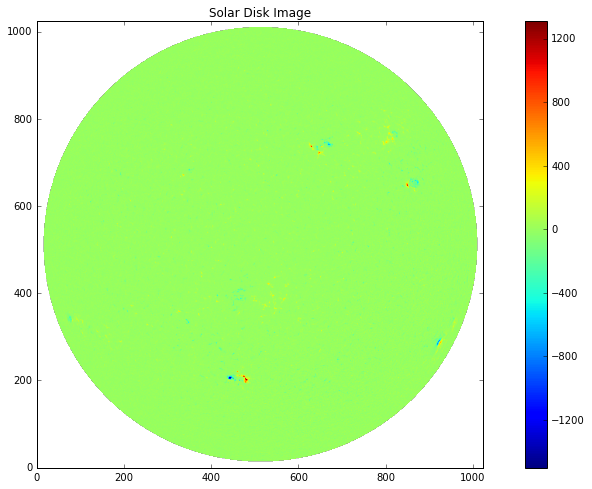

In [21]:
plt.figure(figsize = (15,8));
a1 = np.ma.masked_where(clean_data_mdi == 0.0, clean_data_mdi)
plt.imshow(a1, origin='lower');
plt.title("Solar Disk Image")
# plt.xlim((400,500))
# plt.ylim((150,250))
plt.colorbar()

plt.show()

#### Original ( HMI )

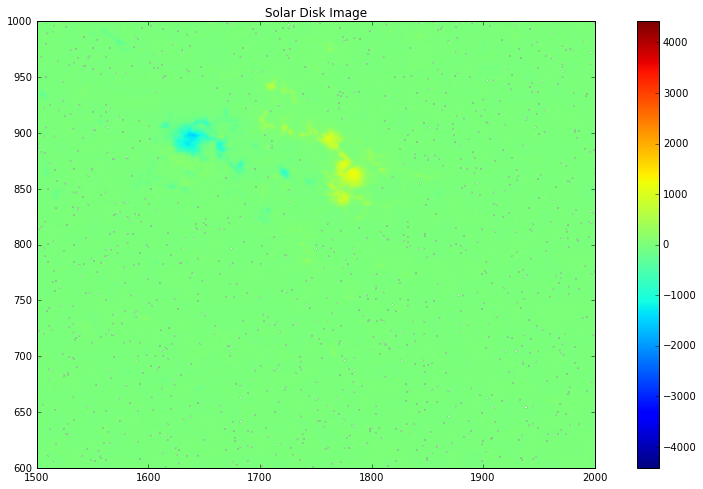

In [22]:
plt.figure(figsize = (15,8));
b = np.ma.masked_where(clean_data_hmi == 0.0, clean_data_hmi)
plt.imshow(b, origin='lower');
plt.title("Solar Disk Image")
plt.xlim((1500,2000))
plt.ylim((600,1000))
plt.colorbar()

plt.show()

#### Equal Area Cylindrical Transformation ( MDI )

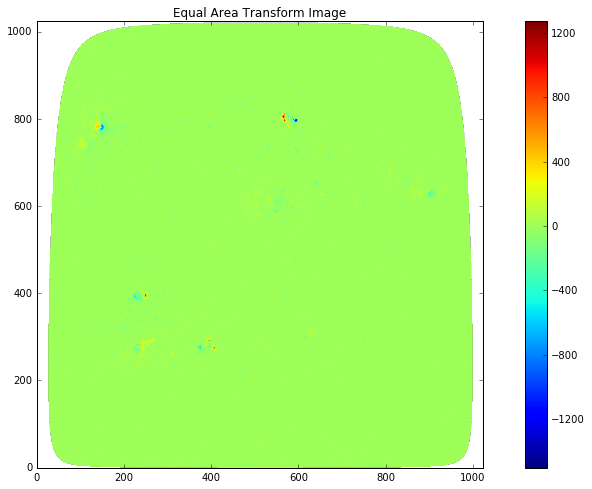

In [23]:
plt.figure(figsize = (15,8));
a2 = np.ma.masked_where(trans_data_mdi == 0.0, trans_data_mdi)
plt.imshow(a2, origin='lower')
plt.title("Equal Area Transform Image")
# plt.xlim((200,450))
# plt.ylim((200,450))
plt.colorbar()
plt.show()

#### Equal Area Cylindrical Transformation ( HMI )

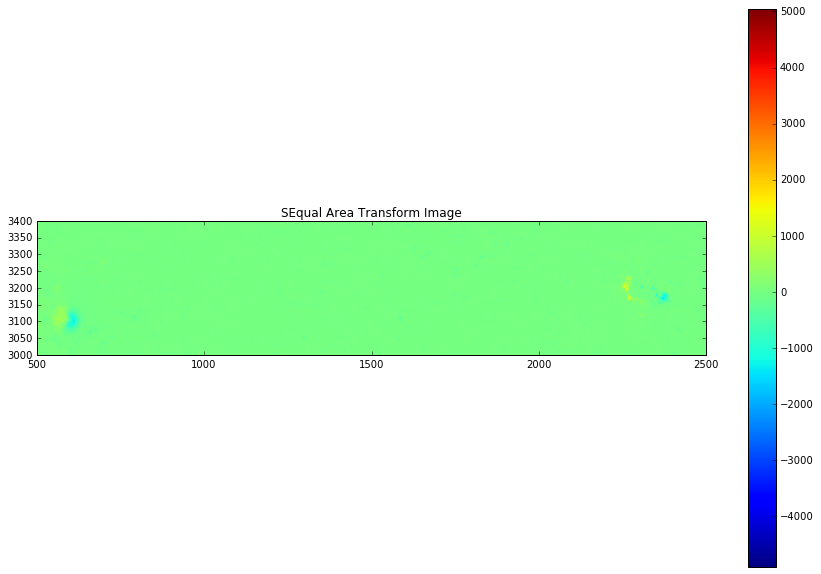

In [24]:
plt.figure(figsize = (15,10));
b2 = np.ma.masked_where(trans_data_hmi == 0.0, trans_data_hmi)
plt.imshow(b2, origin='lower');
plt.title("SEqual Area Transform Image")
plt.xlim((500,2500))
plt.ylim((3000,3400))
plt.colorbar()
plt.show()

## Find Active Regions of Magnetic Fields

    1. Take abs of data to identify active regions, the signs doesn't matter
    2. Smooth the data with smoothing Kernal
        Will have to explore different types of kernels (shape and sizes) for best results
    3. Apply thresholding, 
        will have to explore threshold values around 150 G for MDI
        will have to explore threshold values around 150 * 4 for HMI due to image resolution    
    4. Apply Convolution with Fourier Transforms 

We are making an Active Region Map

    0 -> not active region
    1 -> active region

In [25]:
from astropy.convolution import convolve_fft, convolve

In [26]:
import astropy.convolution

1. Take abs of data to identify active regions, the signs doesn't matter

In [27]:
# Take abs of data to identify active regions, the signs doesn't matter
data_abs_mdi = np.abs(trans_data_mdi)
data_abs_hmi = np.abs(trans_data_hmi)

### 2D Smoothing Kernels ( MDI )
    A std of 8 seems to be the best comprimise between capturing most of the surface area of an active region
    and not capturing regions that are not fully formed active regions. 

In [28]:
param = 4

In [29]:
gauss = astropy.convolution.Gaussian2DKernel(stddev=param)
box = astropy.convolution.Box2DKernel(width=param) # width = pixels?
AiryDisk = astropy.convolution.AiryDisk2DKernel(radius = param) # radius = pixels?
mex = astropy.convolution.MexicanHat2DKernel(width=param) # width = stddev?
trap = astropy.convolution.TrapezoidDisk2DKernel(param) # width = what?

### Convolutions ( MDI )

In [30]:
gauss_data_mdi = convolve_fft(data_abs_mdi, gauss)

In [31]:
box_data_mdi = convolve_fft(data_abs_mdi, box)
AiryDisk_data_mdi = convolve_fft(data_abs_mdi, AiryDisk)
mex_data_mdi = convolve_fft(data_abs_mdi, mex)
trap_data_mdi = convolve_fft(data_abs_mdi, trap)

In [32]:
x_limits_mdi = [100, 700]
y_limits_mdi = [650, 850]

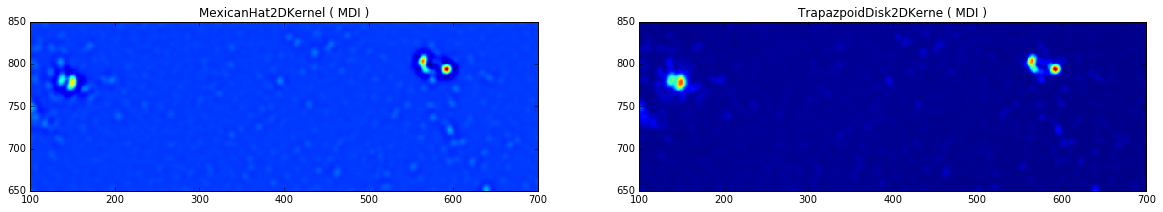

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches((20,20))
ax1.set_title('MexicanHat2DKernel ( MDI )')
ax2.set_title('TrapazpoidDisk2DKerne ( MDI )')
ax1.set_xlim(x_limits_mdi)
ax1.set_ylim(y_limits_mdi)
ax2.set_xlim(x_limits_mdi)
ax2.set_ylim(y_limits_mdi)
ax1.imshow(mex_data_mdi, interpolation='none', origin='lower');
ax2.imshow(trap_data_mdi, interpolation='none', origin='lower');

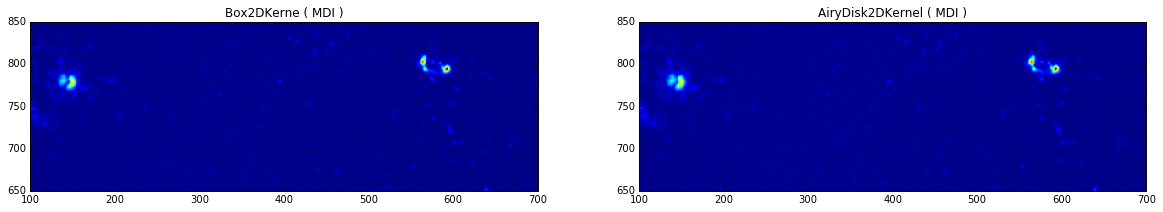

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches((20,20))
ax1.set_title('Box2DKerne ( MDI )')
ax2.set_title('AiryDisk2DKernel ( MDI )')
ax1.set_xlim(x_limits_mdi)
ax1.set_ylim(y_limits_mdi)
ax2.set_xlim(x_limits_mdi)
ax2.set_ylim(y_limits_mdi)
ax1.imshow(box_data_mdi, interpolation='none', origin='lower');
ax2.imshow(AiryDisk_data_mdi, interpolation='none', origin='lower');

### The Gaussian Kernel seems to provide the smoothest convolution for MDI 
    The uneventful background ranges between 0 and 50 Gauss 

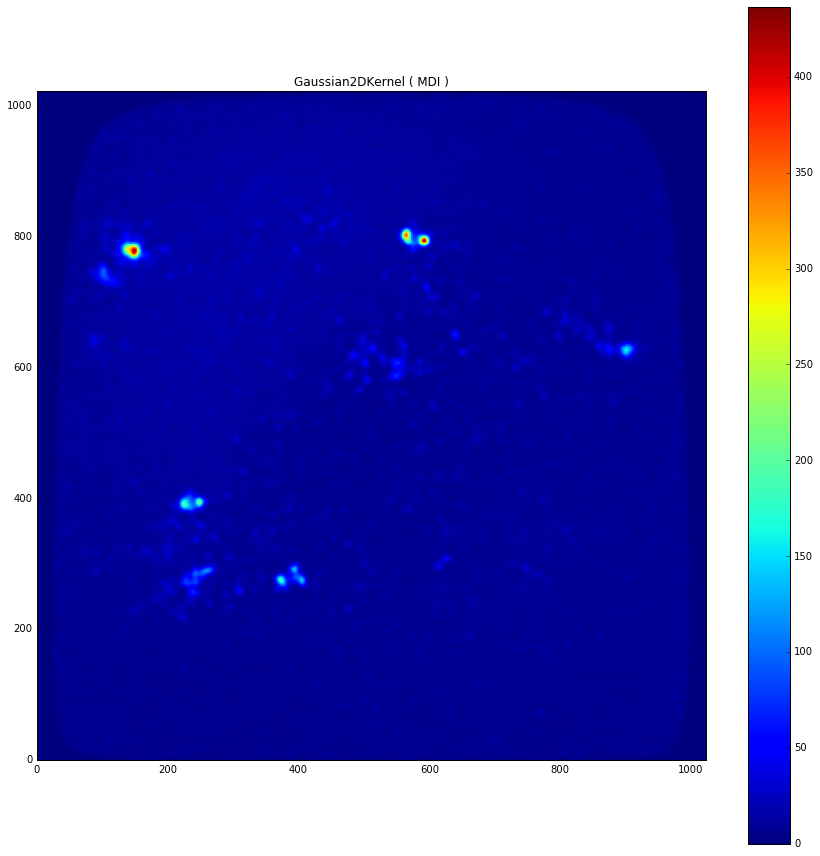

In [35]:
plt.figure(figsize = (15,15));
plt.imshow(gauss_data_mdi, interpolation='none', origin='lower');
plt.title("Gaussian2DKernel ( MDI )")
plt.colorbar()
# plt.xlim(x_limits_mdi)
# plt.ylim(y_limits_mdi)
# plt.xlim((200,450))
# plt.ylim((200,450))
plt.show()

### 2D Smoothing Kernels ( MDI )
    Explore values around 10 * 4 

In [36]:
param = 40

In [37]:
gauss = astropy.convolution.Gaussian2DKernel(stddev=param)
box = astropy.convolution.Box2DKernel(width=param) # width = pixels?
AiryDisk = astropy.convolution.AiryDisk2DKernel(radius = param) # radius = pixels?
mex = astropy.convolution.MexicanHat2DKernel(width=param) # width = stddev?
trap = astropy.convolution.TrapezoidDisk2DKernel(param) # width = what?

In [38]:
start = time()
gauss_data_hmi = convolve_fft(data_abs_hmi, gauss)
box_data_hmi = convolve_fft(data_abs_hmi, box)
AiryDisk_data_hmi = convolve_fft(data_abs_hmi, AiryDisk)
mex_data_hmi = convolve_fft(data_abs_hmi, mex)
trap_data_hmi = convolve_fft(data_abs_hmi, trap)
end = time()
print "Time Elapsed = {:.4} mins ".format((end - start)/60)

Time Elapsed = 3.841 mins 


In [39]:
x_limits = [500,2500]
y_limits = [3000,3400]

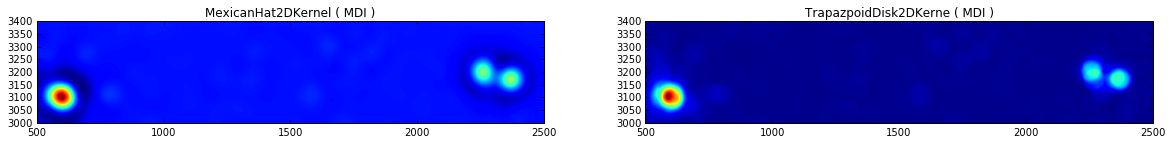

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches((20,20))
ax1.set_title('MexicanHat2DKernel ( MDI )')
ax2.set_title('TrapazpoidDisk2DKerne ( MDI )')
ax1.set_xlim(x_limits)
ax1.set_ylim(y_limits)
ax2.set_xlim(x_limits)
ax2.set_ylim(y_limits)
ax1.imshow(mex_data_hmi, interpolation='none', origin='lower');
ax2.imshow(trap_data_hmi, interpolation='none', origin='lower');

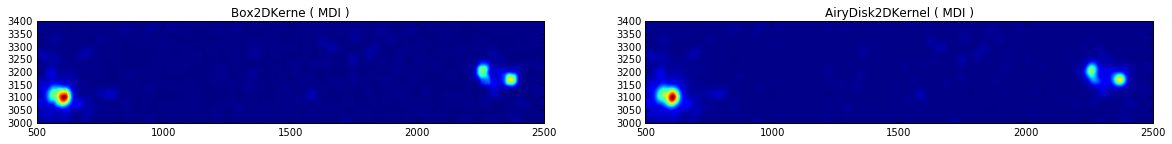

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches((20,20))
ax1.set_title('Box2DKerne ( MDI )')
ax2.set_title('AiryDisk2DKernel ( MDI )')
ax1.set_xlim(x_limits)
ax1.set_ylim(y_limits)
ax2.set_xlim(x_limits)
ax2.set_ylim(y_limits)
ax1.imshow(box_data_hmi, interpolation='none', origin='lower');
ax2.imshow(AiryDisk_data_hmi, interpolation='none', origin='lower');

### The Gaussian Kernel seems to provide the smoothest convolution for HMI
    The uneventful background ranges between 0 and 30 Gauss

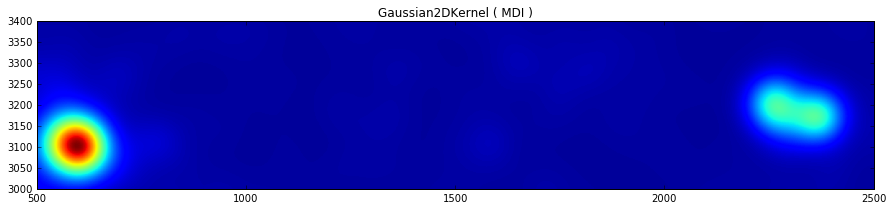

In [42]:
plt.figure(figsize = (15,15));
plt.imshow(gauss_data_hmi, interpolation='none', origin='lower');
plt.title("Gaussian2DKernel ( MDI )")
#plt.colorbar()
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.show()

### Create Active Region Mask
    In Mask:
        0 --> Not Active
        1 --> Active
    Mask will filter original image of magnetic fields less than some value, k. 
    The resulting image will only have the active region remaining. 

### Active Region Mask ( MDI )
    In this section, we will find the optimal value for the flux thresholds 

### MDI 

In [43]:
def get_active_region_mask(convolved_image, trans_image, flux_thresh ):
    convolved_image_copy = convolved_image.copy()
    # one-hot encode image based on flux threshold value
    convolved_image_copy[convolved_image_copy < flux_thresh] = 0.
    convolved_image_copy[convolved_image_copy >= flux_thresh] = 1 
    # filter original image with active region map 
    return  np.where(convolved_image_copy !=0.0 , trans_image, convolved_image_copy)

In [44]:
flux_thresh_mdi = 85 # <-- use as offical cut off value for MDI 
active_region_image = get_active_region_mask(gauss_data_mdi, trans_data_mdi, flux_thresh_mdi )

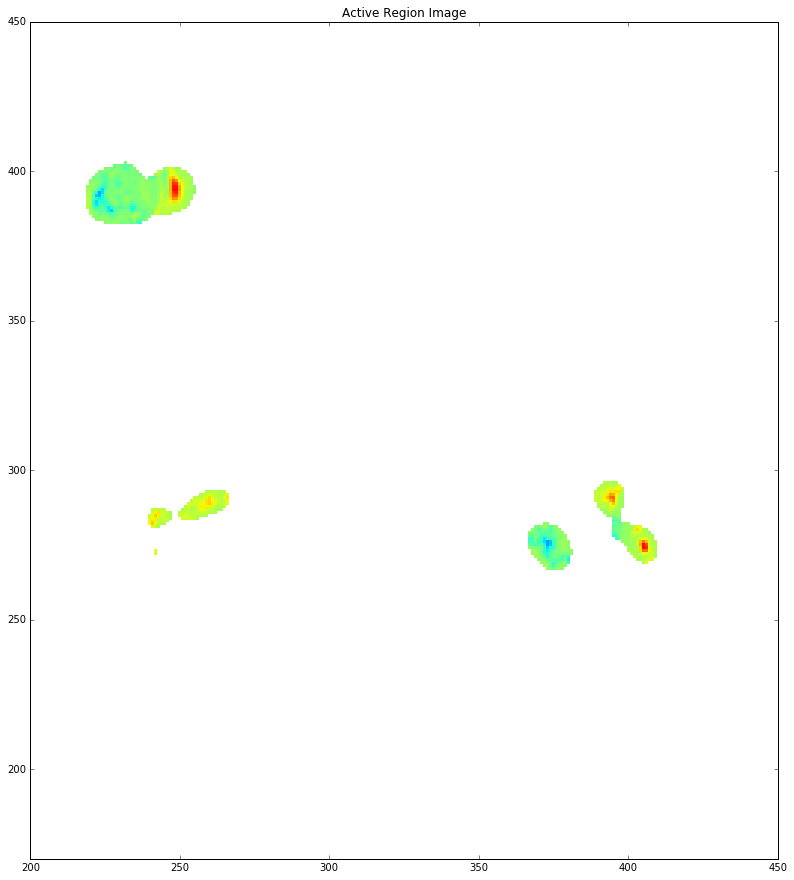

In [45]:
# bottle left active region 
plt.figure(figsize = (15,15));
test_plot  = np.ma.masked_where(active_region_image == 0.0, active_region_image)
plt.imshow(test_plot, interpolation='none', origin='lower');
plt.title("Active Region Image")
#plt.colorbar()
# plt.xlim((100,700))
# plt.ylim((650,850))
plt.xlim((200,450))
plt.ylim((170,450))
plt.show()

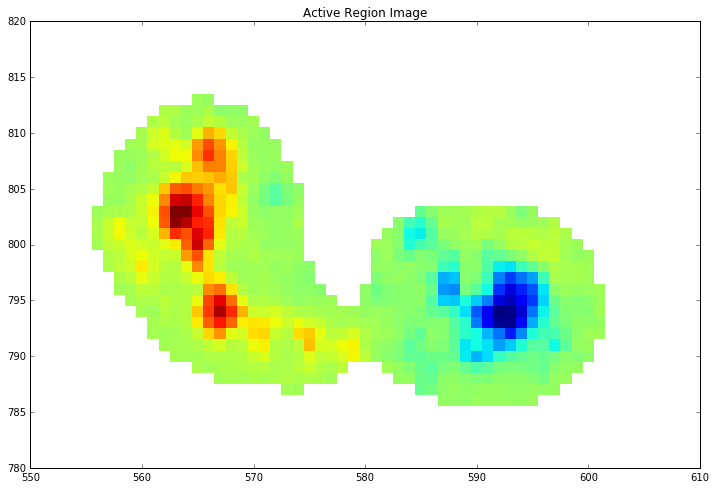

In [46]:
# top right active region
plt.figure(figsize = (12,12));
test_plot  = np.ma.masked_where(active_region_image == 0.0, active_region_image)
plt.imshow(test_plot, interpolation='none', origin='lower');
plt.title("Active Region Image")
#plt.colorbar()
plt.xlim((550,610))
plt.ylim((780,820))
plt.show()

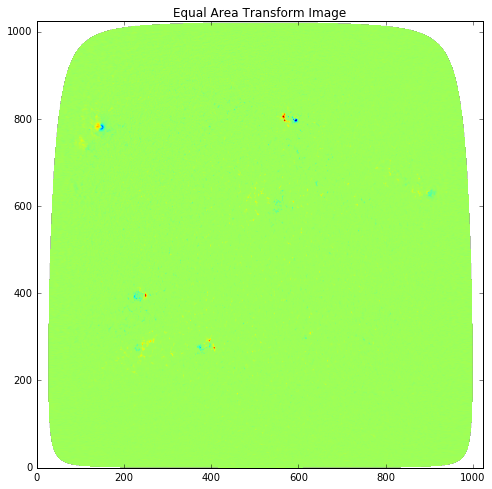

In [47]:
plt.figure(figsize = (15,8));
a2 = np.ma.masked_where(trans_data_mdi == 0.0, trans_data_mdi)
plt.imshow(a2, origin='lower')
plt.title("Equal Area Transform Image")
# left cluster xlim
#plt.xlim((100,700))
# right cluster xlim
# plt.xlim((550,620))
# plt.ylim((750,850))
#plt.colorbar()
plt.show()

### HMI

In [48]:
flux_thresh_hmi = 85 # <-- use as offical cut off value for MDI 
active_region_image_hmi = get_active_region_mask(gauss_data_hmi, trans_data_hmi, flux_thresh_hmi)

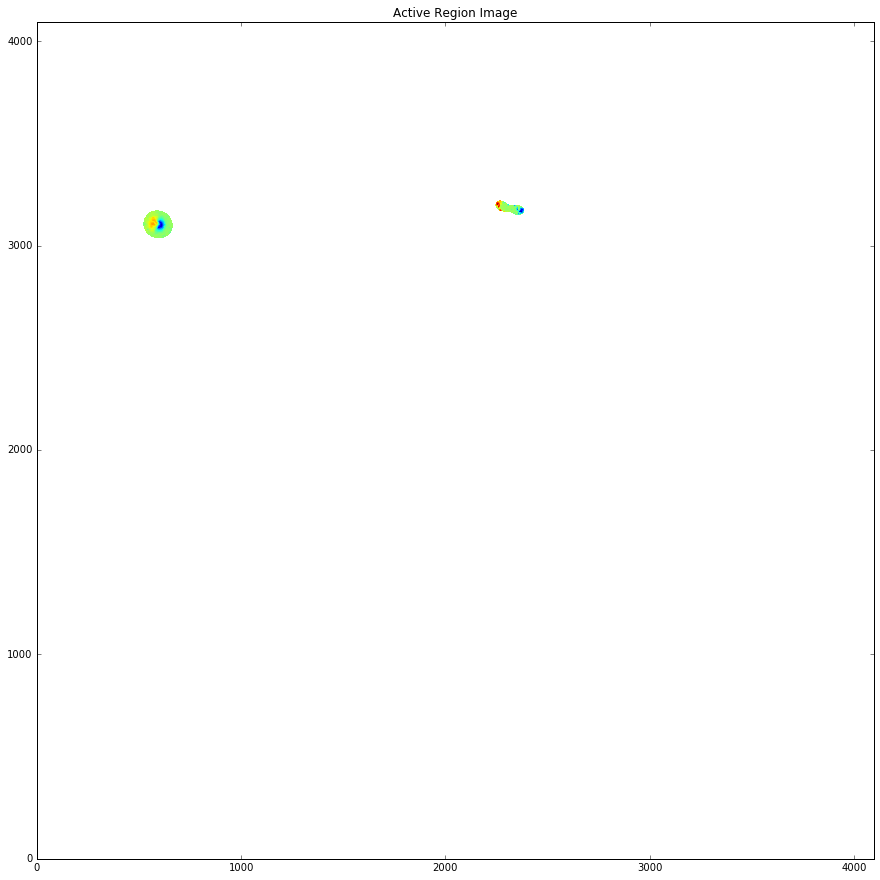

In [49]:
plt.figure(figsize = (15,15));
masked_image_hmi  = np.ma.masked_where(active_region_image_hmi == 0.0, active_region_image_hmi)
plt.imshow(masked_image_hmi, interpolation='none', origin='lower');
plt.title("Active Region Image")
#plt.colorbar()
# plt.xlim((100,700))
# plt.ylim((650,850))
plt.show()

### Load NOAA data

In [52]:
hud_mdi.header["DATE"]

'2011-01-06'

In [53]:
noaa_home = "/Users/Alexander/NASA/noaa_data/"
image_noaa_path = "rgn2011.txt"

In [58]:
pd.read_csv(noaa_home + image_noaa_path, sep=' ').head()

CParserError: Error tokenizing data. C error: Expected 22 fields in line 34, saw 23


###Map to 2D Cartisian Coordinates (i.e. drop the zeros)

In [ ]:
test

In [ ]:
np.unique(smoothing_one)

In [ ]:
x_coords = []
y_coords = []
z_coords = []
coords = []
for i, row in enumerate(np.abs(test)):
    for j, col in enumerate(row):
        if smoothing_one[i,j] == 1:
            x_coords.append(i)
            y_coords.append(j)
            z_coords.append(col)
            coords.append([i,j,col])

In [ ]:
import plotly.plotly as py

In [ ]:
scatter = dict(
    mode = "markers",
    name = "y",
    type = "scatter3d",    
    x =x_coords, y = y_coords, z = z_coords,
    marker = dict( size=2, color="rgb(23, 190, 207)" )
)
clusters = dict(
    alphahull = 7,
    name = "y",
    opacity = 0.1,
    type = "mesh3d",    
    x = x_coords, y = y_coords, z = z_coords
)
layout = dict(
    title = '3d point clustering',
    scene = dict(
        xaxis = dict( zeroline=False ),
        yaxis = dict( zeroline=False ),
        zaxis = dict( zeroline=False ),
    )
)
fig = dict( data=[scatter, clusters], layout=layout )
# Use py.iplot() for IPython notebook
url = py.iplot(fig, filename='3d point clustering')

In [ ]:
url

In [ ]:
print x_coords[0:5]
print y_coords[0:5]
print z_coords[0:5]

In [ ]:
# HDBSCAN doesn't seem to be working out very well
import hdbscan

In [ ]:
cluster = hdbscan.HDBSCAN(min_cluster_size=19)

In [ ]:
model = cluster.fit(coords)

In [ ]:
np.unique(model.labels_)

In [ ]:
len(model.labels_)

In [ ]:
plt.figure(figsize = (15,15));
for x, y, label in zip(x_coords, y_coords,model.labels_ ):
    if label == 0:
        plt.scatter(x,y, c="b", marker='o');
    elif label ==1:
        plt.scatter(x,y, c="r",marker='o');
    elif label == 2: 
        plt.scatter(x,y, c="y",marker='o');
    else:
        plt.scatter(x,y, c="g",marker='o');

##K-Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
k = 2
k_model = KMeans(n_clusters=k, n_jobs = -1)

In [ ]:
model_predict = k_model.fit_predict(coords)

In [ ]:
k_model.inertia_

In [ ]:
silhouette_score(np.array(coords), model_predict)

In [ ]:
k_model.cluster_centers_

In [ ]:
KK = 10

In [ ]:
##### cluster data into K=1..10 clusters #####
K_MAX = 10
KK = range(1,K_MAX+1)

KM = [KMeans(coords,k) for k in KK]
centroids = [cent for (cent,var) in KM]
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]

tot_withinss = [sum(d**2) for d in dist]  # Total within-cluster sum of squares
totss = sum(pdist(X)**2)/X.shape[0]       # The total sum of squares
betweenss = totss - tot_withinss          # The between-cluster sum of squares

##Use Active Mask to Identify Distinct Sunspots

###Peak Detection Code 
    https://gist.github.com/endolith/250860

In [ ]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

In [ ]:
from matplotlib.pyplot import plot, scatter, show

In [ ]:
series = [0,0,0,2,0,0,0,-2,0,0,0,2,0,0,0,-2,0]
maxtab, mintab = peakdet(smoothing_two.flatten(),.3)
plot(smoothing_two)
scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')
show()

In [ ]:
print maxtab.shape
print mintab.shape

In [ ]:
import scipy.fftpack

In [ ]:
fft_result = scipy.fftpack.rfft(data_abs)

In [ ]:
plt.figure(figsize = (15,10));
plt.plot(test, 'b');

##HDBSCAN

Model needs to be tuned to 'see' that there are 2 sunspots clusters, not 3. 
By looking at the contour maps, we see that there are 3 highly dense regions, 
this must be what hdbscan sees as the 3 clusters -- though we want it to find 2 clusters. 

Potential Solutions: maybe we can help the model 'see' the polarity of the field,
this may help to distinguish distinct sunspots (i.e. even though there are 2 highly dense regions near each other, if they have the same polarity, then they are a single sunspot, and not 2)

In [ ]:
import hdbscan

In [ ]:
hdb_result = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=100, gen_min_span_tree=True)

In [ ]:
# active map filtered data
hdb_result = hdb.fit(smoothing_two)

In [ ]:
# original disk data
hdb_result = hdb.fit(trans_data)

In [ ]:
hdb_result.condensed_tree_.plot?

In [ ]:
plt.figure(figsize = (15,10));
hdb_result.condensed_tree_.plot( label_clusters=True);

In [ ]:
hdb_data = hdb_result.condensed_tree_.get_plot_data()

In [ ]:
hdb_data.keys()

In [ ]:
np.unique( hdb_result.labels_)

In [ ]:
test.shape

In [ ]:
dirty_prob = pd.DataFrame(hdb_result.probabilities_)

dirty_prob.fillna(value=0,inplace=True)

clean_prob = dirty_prob.values

In [ ]:
hdb_result.probabilities_

In [ ]:
cluster_colors = [sns.color_palette(desat=sat)[col] 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 
                  zip(hdb_result.labels_, hdb_result.probabilities_)]
plt.plot(test, c=cluster_colors);